## Iterative Prisoner's Dilemma (IPD) using Facial Factors

#### Import libraries

In [1]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Import data into pandas dataframe

In [92]:
df=pd.read_csv('training_data.csv')
df=df.fillna('N')

#### Game Behavior Feature Engineering

In [93]:
#assign numbers to states as algorithms like LR need features to be numbers
individual_states_dict={"C":0, "D":1} 
joint_states_dict={"CC":1,"CD":2,"DC":3,"DD":4}

#assign j to roundid to make the rounds range from 1 to 10
j=1

#individual game behavior 
own_state=[] 
opp_state=[] 

self_coop_rate_so_far=[] 
self_coop_counter=0

self_betrayal_rate_so_far=[] 
self_betrayal_counter=0

opp_coop_rate_so_far=[] 
opp_coop_counter=0

opp_betrayal_rate_so_far=[]
opp_betrayal_counter=0

#joint game behavior
CC_so_far=[] 
CC_counter=0

CD_so_far=[] 
CD_counter=0

DC_so_far=[] 
DC_counter=0

DD_so_far=[]
DD_counter=0

relative_score=[]
player_score=0
opponent_score=0

for i in range(0,len(df)):
    df["roundID"][i] = j
    df["next_state"][i] = individual_states_dict[df["next_state"][i][1]] # this will be the target variable
    
    own_state.append(individual_states_dict[df["state"][i][0]]) 
    opp_state.append(individual_states_dict[df["state"][i][1]])
    
    if(df["state"][i][0]=="C"):
        self_coop_counter+=1
        
    if(df["state"][i][0]=="D"):
        self_betrayal_counter+=1
    
    if(df["state"][i][1]=="C"):
        opp_coop_counter+=1
    
    if(df["state"][i][1]=="D"):
        opp_betrayal_counter+=1
        
    if(df["state"][i]=="CC"):
        CC_counter+=1
        player_score+=5
        opponent_score+=5
    
    if(df["state"][i]=="CD"):
        CD_counter+=1
        player_score+=0
        opponent_score+=10
        
    if(df["state"][i]=="DC"):
        DC_counter+=1
        player_score+=10
        opponent_score+=0
        
    if(df["state"][i]=="DD"):
        DD_counter+=1
        player_score+=1
        opponent_score+=1

    df["state"][i] = joint_states_dict[df["state"][i]]
    
    self_coop_rate_so_far.append(self_coop_counter/10)
    self_betrayal_rate_so_far.append(self_betrayal_counter/10)
    opp_coop_rate_so_far.append(opp_coop_counter/10)
    opp_betrayal_rate_so_far.append(opp_betrayal_counter/10)
    
    CC_so_far.append(CC_counter/10)
    CD_so_far.append(CD_counter/10)
    DC_so_far.append(DC_counter/10)
    DD_so_far.append(DD_counter/10)
    
    relative_score.append(float(player_score)/float(player_score+opponent_score))
    
    if(i<len(df)-1 and df["playerID"][i]==df["playerID"][i+1]): #check if we are still processing the same player details
        j+=1
    else:
        #reset round number to 1 and counters to 0
        j=1
        self_coop_counter=0
        self_betrayal_counter=0
        opp_coop_counter=0
        opp_betrayal_counter=0
        CC_counter=0
        CD_counter=0
        DC_counter=0
        DD_counter=0
        player_score=0
        opponent_score=0
        
df["roundID"][len(df)-1] = j+1 #assign round number to the last row of data

c:\users\seahorse\myenv\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\seahorse\myenv\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\seahorse\myenv\lib\site-packages\ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\seahorse\myenv\lib\site-packages\ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

#### Assign computed Game Behavior to dataframe and view it in tranformed.csv

In [94]:
df=df.assign(own_state=own_state)
df=df.assign(opp_state=opp_state)
df=df.assign(self_coop_rate_so_far=self_coop_rate_so_far)
df=df.assign(self_betrayal_rate_so_far=self_betrayal_rate_so_far)
df=df.assign(opp_coop_rate_so_far=opp_coop_rate_so_far)
df=df.assign(opp_betrayal_rate_so_far=opp_betrayal_rate_so_far)
df=df.assign(CC_so_far=CC_so_far)
df=df.assign(CD_so_far=CD_so_far)
df=df.assign(DC_so_far=DC_so_far)
df=df.assign(DD_so_far=DD_so_far)
df=df.assign(relative_score=relative_score)
df.to_csv("transformed.csv", encoding='utf-8', index=False)

#### Target variable dataframe

In [95]:
df_target = df["next_state"]
df_target= df_target.astype('int')

#### Reference paper (Hoegen et al., 2017) features

In [96]:
self_last_pick = df["own_state"]
opp_last_pick = df["opp_state"]
prev_state = df["state"]
roundID = df["roundID"]
relativeScore = df["relative_score"]
cooperation_rate = df["self_coop_rate_so_far"]
CC_rate = df["CC_so_far"]
CD_rate = df["CD_so_far"]
DC_rate = df["DC_so_far"]
DD_rate = df["DD_so_far"]
AU6 = df["AU6"]
AU10 = df["AU10"]
AU12 = df["AU12"]
AU14 = df["AU14"]
AU17 = df["AU17"]
AU24 = df["AU24"]

ref_df_features = pd.DataFrame({'roundID':roundID, 'self_last_pick':self_last_pick,'opp_last_pick':opp_last_pick,
                              'relative_score':relative_score,'cooperation_rate':cooperation_rate,'CC_rate':CC_rate,
                              'CD_rate':CD_rate,'DC_rate':DC_rate,'DD_rate':DD_rate,'AU6':AU6,
                              'AU10':AU10,'AU12':AU12,'AU14':AU14,'AU17':AU17,'AU24':AU24})
print(ref_df_features)

      roundID  self_last_pick  opp_last_pick  relative_score  \
0           1               0              0        0.500000   
1           2               0              0        0.500000   
2           3               0              0        0.500000   
3           4               0              0        0.500000   
4           5               0              0        0.500000   
5           6               0              0        0.500000   
6           7               0              0        0.500000   
7           8               0              0        0.500000   
8           9               0              0        0.500000   
9           1               0              0        0.500000   
10          2               0              0        0.500000   
11          3               0              0        0.500000   
12          4               0              0        0.500000   
13          5               0              0        0.500000   
14          6               0           

#### Novel model features

In [97]:
self_last_pick = df["own_state"]
opp_last_pick = df["opp_state"]
prev_state = df["state"]
roundID = df["roundID"]
self_coop_rate_so_far = df["self_coop_rate_so_far"]
self_betrayal_rate_so_far = df["self_betrayal_rate_so_far"]
opp_coop_rate_so_far = df["opp_coop_rate_so_far"]
opp_betrayal_rate_so_far = df["opp_betrayal_rate_so_far"]
Fac1 = df["Fac1"]
Fac2 = df["Fac2"]
Fac3 = df["Fac3"]
Fac4 = df["Fac4"]
Fac5 = df["Fac5"]
Fac6 = df["Fac6"]

novel_df_features = pd.DataFrame({'self_last_pick':self_last_pick,'opp_last_pick':opp_last_pick,'prev_state':prev_state,
                              'roundID':roundID,'self_coop_rate_so_far':self_coop_rate_so_far,
                              'self_betrayal_rate_so_far':self_betrayal_rate_so_far,
                              'opp_coop_rate_so_far':opp_coop_rate_so_far,'opp_betrayal_rate_so_far':opp_betrayal_rate_so_far,
                              'Fac1':Fac1,'Fac2':Fac2,'Fac3':Fac3,'Fac4':Fac4,'Fac5':Fac5,'Fac6':Fac6})
print(novel_df_features)

      self_last_pick  opp_last_pick prev_state  roundID  \
0                  0              0          1        1   
1                  0              0          1        2   
2                  0              0          1        3   
3                  0              0          1        4   
4                  0              0          1        5   
5                  0              0          1        6   
6                  0              0          1        7   
7                  0              0          1        8   
8                  0              0          1        9   
9                  0              0          1        1   
10                 0              0          1        2   
11                 0              0          1        3   
12                 0              0          1        4   
13                 0              0          1        5   
14                 0              0          1        6   
15                 0              0          1        7 

#### Cross-validation

In [98]:
def train_test(clf,features,target):
    folds = 5974
    tscv = TimeSeriesSplit(n_splits=folds)
    foldid = 0
    totacc = 0.
    ytlog = []
    yplog = []
    totalcount=0
    
    for train_index, test_index in tscv.split(features):
        foldid += 1
        X_train, X_test = features.iloc[train_index],features.iloc[test_index]
        y_train, y_test = target[train_index], target[test_index]

        if foldid>55:
            clf.fit(X_train.values, y_train)
            y_pred = clf.predict(X_test.values)
            acc = accuracy_score(y_pred, y_test)
            totacc += acc
            totalcount+=1
            ytlog += list(y_test)
            yplog += list(y_pred)
            print(str(foldid)+" "+str(acc))

    print("Average Accuracy: %0.3f" % (totacc / totalcount))
    print(classification_report(ytlog, yplog,digits=3))

#### Logistic Regression

In [99]:
from sklearn.linear_model import LogisticRegression
train_test(LogisticRegression(),novel_df_features,df_target)

56 1.0
57 1.0
58 1.0
59 1.0
60 0.0
61 1.0
62 1.0
63 1.0
64 0.0
65 1.0
66 1.0
67 0.0
68 1.0
69 1.0
70 1.0
71 0.0
72 1.0
73 1.0
74 1.0
75 0.0
76 0.0
77 0.0
78 1.0
79 1.0
80 1.0
81 1.0
82 1.0
83 0.0
84 1.0
85 1.0
86 1.0
87 1.0
88 1.0
89 1.0
90 1.0
91 1.0
92 1.0
93 1.0
94 0.0
95 1.0
96 1.0
97 0.0
98 1.0
99 1.0
100 1.0
101 0.0
102 1.0
103 1.0
104 1.0
105 1.0
106 1.0
107 1.0
108 1.0
109 1.0
110 0.0
111 0.0
112 0.0
113 0.0
114 1.0
115 1.0
116 1.0
117 1.0
118 1.0
119 1.0
120 1.0
121 1.0
122 1.0
123 1.0
124 1.0
125 1.0
126 1.0
127 1.0
128 0.0
129 1.0
130 0.0
131 1.0
132 1.0
133 0.0
134 0.0
135 0.0
136 0.0
137 1.0
138 0.0
139 1.0
140 0.0
141 1.0
142 0.0
143 1.0
144 1.0
145 0.0
146 0.0
147 1.0
148 1.0
149 1.0
150 0.0
151 0.0
152 0.0
153 1.0
154 1.0
155 1.0
156 1.0
157 1.0
158 1.0
159 0.0
160 1.0
161 1.0
162 1.0
163 1.0
164 1.0
165 1.0
166 1.0
167 1.0
168 1.0
169 1.0
170 1.0
171 1.0
172 1.0
173 0.0
174 0.0
175 0.0
176 1.0
177 1.0
178 1.0
179 1.0
180 1.0
181 1.0
182 1.0
183 1.0
184 1.0
185 1.0
186 

1077 1.0
1078 1.0
1079 1.0
1080 1.0
1081 1.0
1082 1.0
1083 1.0
1084 1.0
1085 1.0
1086 1.0
1087 1.0
1088 1.0
1089 1.0
1090 1.0
1091 0.0
1092 1.0
1093 1.0
1094 1.0
1095 0.0
1096 0.0
1097 0.0
1098 1.0
1099 1.0
1100 1.0
1101 1.0
1102 0.0
1103 0.0
1104 1.0
1105 1.0
1106 0.0
1107 1.0
1108 1.0
1109 1.0
1110 1.0
1111 1.0
1112 1.0
1113 1.0
1114 1.0
1115 1.0
1116 1.0
1117 0.0
1118 1.0
1119 1.0
1120 1.0
1121 1.0
1122 1.0
1123 1.0
1124 1.0
1125 1.0
1126 1.0
1127 1.0
1128 1.0
1129 1.0
1130 1.0
1131 1.0
1132 1.0
1133 1.0
1134 1.0
1135 1.0
1136 1.0
1137 1.0
1138 1.0
1139 1.0
1140 1.0
1141 1.0
1142 1.0
1143 1.0
1144 1.0
1145 1.0
1146 1.0
1147 1.0
1148 1.0
1149 1.0
1150 1.0
1151 1.0
1152 1.0
1153 1.0
1154 1.0
1155 1.0
1156 1.0
1157 1.0
1158 1.0
1159 1.0
1160 1.0
1161 1.0
1162 1.0
1163 1.0
1164 1.0
1165 1.0
1166 1.0
1167 1.0
1168 1.0
1169 1.0
1170 1.0
1171 1.0
1172 0.0
1173 0.0
1174 0.0
1175 0.0
1176 0.0
1177 1.0
1178 1.0
1179 1.0
1180 0.0
1181 1.0
1182 0.0
1183 1.0
1184 1.0
1185 1.0
1186 1.0
1187 1.0
1

1992 1.0
1993 1.0
1994 1.0
1995 1.0
1996 0.0
1997 1.0
1998 1.0
1999 0.0
2000 0.0
2001 1.0
2002 0.0
2003 0.0
2004 0.0
2005 0.0
2006 1.0
2007 1.0
2008 1.0
2009 1.0
2010 0.0
2011 1.0
2012 1.0
2013 1.0
2014 0.0
2015 1.0
2016 0.0
2017 1.0
2018 1.0
2019 0.0
2020 1.0
2021 1.0
2022 1.0
2023 1.0
2024 0.0
2025 1.0
2026 0.0
2027 1.0
2028 1.0
2029 0.0
2030 1.0
2031 1.0
2032 1.0
2033 1.0
2034 1.0
2035 1.0
2036 1.0
2037 1.0
2038 1.0
2039 1.0
2040 1.0
2041 1.0
2042 1.0
2043 1.0
2044 1.0
2045 1.0
2046 1.0
2047 1.0
2048 1.0
2049 1.0
2050 1.0
2051 1.0
2052 1.0
2053 1.0
2054 1.0
2055 1.0
2056 1.0
2057 1.0
2058 1.0
2059 1.0
2060 1.0
2061 1.0
2062 1.0
2063 1.0
2064 1.0
2065 0.0
2066 1.0
2067 0.0
2068 0.0
2069 1.0
2070 1.0
2071 1.0
2072 0.0
2073 1.0
2074 0.0
2075 1.0
2076 1.0
2077 1.0
2078 0.0
2079 1.0
2080 1.0
2081 1.0
2082 0.0
2083 1.0
2084 1.0
2085 0.0
2086 1.0
2087 0.0
2088 0.0
2089 0.0
2090 1.0
2091 0.0
2092 0.0
2093 0.0
2094 0.0
2095 0.0
2096 1.0
2097 1.0
2098 0.0
2099 1.0
2100 0.0
2101 0.0
2102 0.0
2

2903 0.0
2904 1.0
2905 0.0
2906 1.0
2907 1.0
2908 0.0
2909 1.0
2910 1.0
2911 1.0
2912 0.0
2913 0.0
2914 0.0
2915 1.0
2916 0.0
2917 1.0
2918 0.0
2919 0.0
2920 0.0
2921 0.0
2922 0.0
2923 0.0
2924 1.0
2925 1.0
2926 1.0
2927 0.0
2928 1.0
2929 0.0
2930 0.0
2931 0.0
2932 1.0
2933 1.0
2934 0.0
2935 0.0
2936 1.0
2937 1.0
2938 0.0
2939 0.0
2940 1.0
2941 1.0
2942 0.0
2943 1.0
2944 0.0
2945 1.0
2946 1.0
2947 1.0
2948 0.0
2949 0.0
2950 0.0
2951 1.0
2952 1.0
2953 1.0
2954 1.0
2955 1.0
2956 1.0
2957 1.0
2958 1.0
2959 1.0
2960 1.0
2961 1.0
2962 1.0
2963 1.0
2964 1.0
2965 1.0
2966 1.0
2967 1.0
2968 1.0
2969 1.0
2970 1.0
2971 1.0
2972 1.0
2973 1.0
2974 0.0
2975 0.0
2976 1.0
2977 1.0
2978 1.0
2979 1.0
2980 1.0
2981 1.0
2982 1.0
2983 1.0
2984 0.0
2985 1.0
2986 0.0
2987 1.0
2988 1.0
2989 1.0
2990 1.0
2991 1.0
2992 0.0
2993 0.0
2994 1.0
2995 0.0
2996 1.0
2997 0.0
2998 1.0
2999 1.0
3000 1.0
3001 1.0
3002 1.0
3003 0.0
3004 0.0
3005 0.0
3006 0.0
3007 0.0
3008 1.0
3009 1.0
3010 1.0
3011 1.0
3012 1.0
3013 1.0
3

3821 1.0
3822 1.0
3823 1.0
3824 1.0
3825 1.0
3826 1.0
3827 1.0
3828 1.0
3829 1.0
3830 1.0
3831 1.0
3832 1.0
3833 1.0
3834 1.0
3835 1.0
3836 1.0
3837 1.0
3838 1.0
3839 1.0
3840 1.0
3841 1.0
3842 1.0
3843 1.0
3844 0.0
3845 0.0
3846 1.0
3847 0.0
3848 1.0
3849 1.0
3850 1.0
3851 1.0
3852 0.0
3853 0.0
3854 0.0
3855 1.0
3856 0.0
3857 1.0
3858 0.0
3859 0.0
3860 1.0
3861 1.0
3862 1.0
3863 1.0
3864 1.0
3865 1.0
3866 1.0
3867 1.0
3868 1.0
3869 1.0
3870 1.0
3871 1.0
3872 1.0
3873 1.0
3874 1.0
3875 1.0
3876 1.0
3877 0.0
3878 1.0
3879 1.0
3880 0.0
3881 0.0
3882 1.0
3883 0.0
3884 0.0
3885 1.0
3886 1.0
3887 1.0
3888 1.0
3889 1.0
3890 1.0
3891 0.0
3892 1.0
3893 0.0
3894 1.0
3895 1.0
3896 1.0
3897 1.0
3898 0.0
3899 1.0
3900 0.0
3901 0.0
3902 1.0
3903 0.0
3904 1.0
3905 1.0
3906 0.0
3907 0.0
3908 0.0
3909 1.0
3910 1.0
3911 1.0
3912 1.0
3913 1.0
3914 0.0
3915 1.0
3916 0.0
3917 0.0
3918 0.0
3919 0.0
3920 0.0
3921 1.0
3922 1.0
3923 1.0
3924 0.0
3925 1.0
3926 1.0
3927 1.0
3928 0.0
3929 0.0
3930 0.0
3931 1.0
3

4732 1.0
4733 1.0
4734 1.0
4735 1.0
4736 1.0
4737 1.0
4738 1.0
4739 1.0
4740 1.0
4741 1.0
4742 1.0
4743 1.0
4744 1.0
4745 1.0
4746 1.0
4747 1.0
4748 1.0
4749 1.0
4750 1.0
4751 1.0
4752 1.0
4753 1.0
4754 1.0
4755 1.0
4756 1.0
4757 1.0
4758 1.0
4759 1.0
4760 1.0
4761 1.0
4762 1.0
4763 1.0
4764 1.0
4765 1.0
4766 1.0
4767 1.0
4768 1.0
4769 1.0
4770 1.0
4771 1.0
4772 1.0
4773 1.0
4774 1.0
4775 1.0
4776 1.0
4777 1.0
4778 1.0
4779 1.0
4780 1.0
4781 1.0
4782 1.0
4783 1.0
4784 1.0
4785 0.0
4786 1.0
4787 1.0
4788 1.0
4789 1.0
4790 1.0
4791 1.0
4792 1.0
4793 1.0
4794 1.0
4795 1.0
4796 1.0
4797 1.0
4798 1.0
4799 1.0
4800 1.0
4801 1.0
4802 1.0
4803 1.0
4804 1.0
4805 1.0
4806 1.0
4807 1.0
4808 1.0
4809 1.0
4810 1.0
4811 1.0
4812 1.0
4813 1.0
4814 1.0
4815 1.0
4816 1.0
4817 1.0
4818 1.0
4819 1.0
4820 1.0
4821 1.0
4822 1.0
4823 1.0
4824 1.0
4825 1.0
4826 1.0
4827 1.0
4828 1.0
4829 1.0
4830 1.0
4831 1.0
4832 1.0
4833 1.0
4834 1.0
4835 1.0
4836 1.0
4837 1.0
4838 1.0
4839 0.0
4840 0.0
4841 1.0
4842 1.0
4

5649 0.0
5650 1.0
5651 0.0
5652 1.0
5653 0.0
5654 0.0
5655 0.0
5656 1.0
5657 1.0
5658 1.0
5659 0.0
5660 0.0
5661 1.0
5662 1.0
5663 0.0
5664 1.0
5665 1.0
5666 0.0
5667 0.0
5668 0.0
5669 0.0
5670 0.0
5671 1.0
5672 0.0
5673 0.0
5674 1.0
5675 0.0
5676 0.0
5677 0.0
5678 0.0
5679 0.0
5680 1.0
5681 1.0
5682 1.0
5683 1.0
5684 1.0
5685 1.0
5686 1.0
5687 1.0
5688 0.0
5689 1.0
5690 0.0
5691 0.0
5692 1.0
5693 1.0
5694 0.0
5695 1.0
5696 0.0
5697 1.0
5698 1.0
5699 1.0
5700 1.0
5701 0.0
5702 1.0
5703 0.0
5704 0.0
5705 0.0
5706 1.0
5707 1.0
5708 1.0
5709 0.0
5710 0.0
5711 1.0
5712 1.0
5713 0.0
5714 0.0
5715 1.0
5716 1.0
5717 1.0
5718 1.0
5719 1.0
5720 0.0
5721 0.0
5722 0.0
5723 1.0
5724 1.0
5725 1.0
5726 1.0
5727 1.0
5728 0.0
5729 0.0
5730 0.0
5731 1.0
5732 0.0
5733 0.0
5734 1.0
5735 1.0
5736 1.0
5737 1.0
5738 1.0
5739 1.0
5740 0.0
5741 0.0
5742 0.0
5743 0.0
5744 1.0
5745 1.0
5746 1.0
5747 0.0
5748 0.0
5749 0.0
5750 0.0
5751 0.0
5752 0.0
5753 0.0
5754 0.0
5755 0.0
5756 0.0
5757 1.0
5758 1.0
5759 1.0
5

#### Naive Bayes

In [12]:
from sklearn.naive_bayes import GaussianNB
train_test(GaussianNB(),novel_df_features,df_target)

56 1.0
57 1.0
58 1.0
59 0.0
60 0.0
61 1.0
62 1.0
63 1.0
64 0.0
65 1.0
66 1.0
67 0.0
68 1.0
69 1.0
70 1.0
71 0.0
72 1.0
73 1.0
74 1.0
75 0.0
76 0.0
77 1.0
78 1.0
79 1.0
80 1.0
81 1.0
82 1.0
83 0.0
84 0.0
85 1.0
86 1.0
87 1.0
88 1.0
89 1.0
90 1.0
91 1.0
92 1.0
93 0.0
94 1.0
95 1.0
96 1.0
97 0.0
98 1.0
99 1.0
100 1.0
101 1.0
102 1.0
103 1.0
104 1.0
105 1.0
106 1.0
107 1.0
108 1.0
109 1.0
110 0.0
111 1.0
112 1.0
113 0.0
114 1.0
115 1.0
116 1.0
117 1.0
118 1.0
119 1.0
120 1.0
121 1.0
122 1.0
123 1.0
124 1.0
125 1.0
126 1.0
127 1.0
128 0.0
129 1.0
130 0.0
131 1.0
132 1.0
133 0.0
134 0.0
135 0.0
136 0.0
137 1.0
138 0.0
139 1.0
140 0.0
141 1.0
142 0.0
143 1.0
144 1.0
145 0.0
146 1.0
147 0.0
148 1.0
149 1.0
150 0.0
151 0.0
152 0.0
153 0.0
154 1.0
155 1.0
156 1.0
157 1.0
158 1.0
159 0.0
160 1.0
161 1.0
162 1.0
163 1.0
164 1.0
165 1.0
166 1.0
167 1.0
168 1.0
169 1.0
170 1.0
171 1.0
172 1.0
173 0.0
174 1.0
175 0.0
176 1.0
177 1.0
178 1.0
179 1.0
180 1.0
181 1.0
182 1.0
183 1.0
184 1.0
185 1.0
186 

1111 1.0
1112 1.0
1113 1.0
1114 1.0
1115 1.0
1116 1.0
1117 0.0
1118 1.0
1119 1.0
1120 1.0
1121 1.0
1122 1.0
1123 1.0
1124 1.0
1125 1.0
1126 1.0
1127 1.0
1128 1.0
1129 1.0
1130 1.0
1131 1.0
1132 1.0
1133 1.0
1134 1.0
1135 1.0
1136 1.0
1137 1.0
1138 1.0
1139 1.0
1140 1.0
1141 1.0
1142 1.0
1143 1.0
1144 1.0
1145 1.0
1146 1.0
1147 1.0
1148 1.0
1149 1.0
1150 1.0
1151 1.0
1152 1.0
1153 1.0
1154 1.0
1155 1.0
1156 1.0
1157 1.0
1158 1.0
1159 1.0
1160 1.0
1161 1.0
1162 1.0
1163 1.0
1164 1.0
1165 1.0
1166 1.0
1167 1.0
1168 1.0
1169 1.0
1170 1.0
1171 1.0
1172 0.0
1173 0.0
1174 0.0
1175 0.0
1176 0.0
1177 1.0
1178 1.0
1179 1.0
1180 0.0
1181 0.0
1182 1.0
1183 0.0
1184 1.0
1185 1.0
1186 1.0
1187 1.0
1188 1.0
1189 1.0
1190 1.0
1191 0.0
1192 1.0
1193 1.0
1194 1.0
1195 0.0
1196 0.0
1197 1.0
1198 1.0
1199 1.0
1200 1.0
1201 1.0
1202 1.0
1203 1.0
1204 0.0
1205 0.0
1206 1.0
1207 1.0
1208 1.0
1209 1.0
1210 1.0
1211 0.0
1212 1.0
1213 1.0
1214 1.0
1215 1.0
1216 1.0
1217 1.0
1218 0.0
1219 1.0
1220 0.0
1221 0.0
1

2037 1.0
2038 1.0
2039 1.0
2040 1.0
2041 1.0
2042 1.0
2043 1.0
2044 1.0
2045 1.0
2046 1.0
2047 1.0
2048 1.0
2049 1.0
2050 1.0
2051 1.0
2052 1.0
2053 1.0
2054 1.0
2055 1.0
2056 1.0
2057 1.0
2058 1.0
2059 1.0
2060 1.0
2061 1.0
2062 1.0
2063 1.0
2064 1.0
2065 0.0
2066 1.0
2067 0.0
2068 0.0
2069 1.0
2070 1.0
2071 1.0
2072 0.0
2073 1.0
2074 0.0
2075 1.0
2076 1.0
2077 1.0
2078 0.0
2079 1.0
2080 1.0
2081 1.0
2082 0.0
2083 1.0
2084 0.0
2085 1.0
2086 1.0
2087 1.0
2088 0.0
2089 0.0
2090 0.0
2091 0.0
2092 0.0
2093 0.0
2094 1.0
2095 0.0
2096 1.0
2097 1.0
2098 0.0
2099 1.0
2100 0.0
2101 1.0
2102 0.0
2103 0.0
2104 0.0
2105 1.0
2106 1.0
2107 1.0
2108 1.0
2109 1.0
2110 0.0
2111 0.0
2112 1.0
2113 0.0
2114 1.0
2115 0.0
2116 0.0
2117 0.0
2118 1.0
2119 1.0
2120 1.0
2121 1.0
2122 1.0
2123 1.0
2124 1.0
2125 1.0
2126 1.0
2127 1.0
2128 1.0
2129 1.0
2130 1.0
2131 1.0
2132 1.0
2133 1.0
2134 1.0
2135 1.0
2136 1.0
2137 0.0
2138 0.0
2139 1.0
2140 1.0
2141 1.0
2142 1.0
2143 1.0
2144 1.0
2145 1.0
2146 1.0
2147 0.0
2

2974 1.0
2975 1.0
2976 1.0
2977 1.0
2978 1.0
2979 1.0
2980 1.0
2981 1.0
2982 1.0
2983 0.0
2984 1.0
2985 1.0
2986 0.0
2987 1.0
2988 1.0
2989 1.0
2990 1.0
2991 1.0
2992 0.0
2993 0.0
2994 0.0
2995 1.0
2996 1.0
2997 0.0
2998 1.0
2999 1.0
3000 1.0
3001 1.0
3002 1.0
3003 0.0
3004 0.0
3005 0.0
3006 1.0
3007 1.0
3008 1.0
3009 1.0
3010 1.0
3011 1.0
3012 1.0
3013 1.0
3014 1.0
3015 1.0
3016 1.0
3017 1.0
3018 1.0
3019 1.0
3020 1.0
3021 1.0
3022 1.0
3023 0.0
3024 0.0
3025 0.0
3026 0.0
3027 1.0
3028 0.0
3029 0.0
3030 0.0
3031 1.0
3032 0.0
3033 0.0
3034 1.0
3035 0.0
3036 0.0
3037 1.0
3038 1.0
3039 0.0
3040 1.0
3041 1.0
3042 1.0
3043 0.0
3044 1.0
3045 1.0
3046 0.0
3047 1.0
3048 1.0
3049 1.0
3050 1.0
3051 1.0
3052 0.0
3053 1.0
3054 1.0
3055 1.0
3056 1.0
3057 1.0
3058 1.0
3059 0.0
3060 1.0
3061 1.0
3062 1.0
3063 1.0
3064 1.0
3065 1.0
3066 1.0
3067 1.0
3068 1.0
3069 1.0
3070 1.0
3071 1.0
3072 1.0
3073 1.0
3074 1.0
3075 1.0
3076 1.0
3077 1.0
3078 1.0
3079 1.0
3080 1.0
3081 1.0
3082 1.0
3083 1.0
3084 1.0
3

3898 0.0
3899 1.0
3900 0.0
3901 0.0
3902 1.0
3903 0.0
3904 1.0
3905 1.0
3906 1.0
3907 0.0
3908 1.0
3909 1.0
3910 1.0
3911 1.0
3912 1.0
3913 1.0
3914 0.0
3915 0.0
3916 1.0
3917 1.0
3918 0.0
3919 0.0
3920 0.0
3921 1.0
3922 1.0
3923 1.0
3924 1.0
3925 0.0
3926 1.0
3927 1.0
3928 0.0
3929 1.0
3930 0.0
3931 1.0
3932 1.0
3933 1.0
3934 1.0
3935 1.0
3936 1.0
3937 1.0
3938 1.0
3939 1.0
3940 1.0
3941 1.0
3942 1.0
3943 1.0
3944 1.0
3945 1.0
3946 1.0
3947 1.0
3948 1.0
3949 1.0
3950 1.0
3951 0.0
3952 0.0
3953 0.0
3954 1.0
3955 1.0
3956 1.0
3957 1.0
3958 1.0
3959 1.0
3960 1.0
3961 1.0
3962 1.0
3963 0.0
3964 1.0
3965 1.0
3966 1.0
3967 1.0
3968 1.0
3969 0.0
3970 0.0
3971 0.0
3972 0.0
3973 1.0
3974 1.0
3975 0.0
3976 1.0
3977 1.0
3978 1.0
3979 1.0
3980 1.0
3981 1.0
3982 0.0
3983 1.0
3984 1.0
3985 0.0
3986 1.0
3987 1.0
3988 1.0
3989 1.0
3990 1.0
3991 1.0
3992 1.0
3993 1.0
3994 1.0
3995 1.0
3996 1.0
3997 1.0
3998 1.0
3999 1.0
4000 1.0
4001 1.0
4002 0.0
4003 0.0
4004 1.0
4005 1.0
4006 1.0
4007 0.0
4008 1.0
4

4828 1.0
4829 1.0
4830 0.0
4831 1.0
4832 1.0
4833 1.0
4834 1.0
4835 1.0
4836 1.0
4837 1.0
4838 1.0
4839 0.0
4840 0.0
4841 1.0
4842 1.0
4843 0.0
4844 1.0
4845 1.0
4846 1.0
4847 1.0
4848 0.0
4849 1.0
4850 1.0
4851 1.0
4852 1.0
4853 1.0
4854 1.0
4855 1.0
4856 1.0
4857 0.0
4858 1.0
4859 1.0
4860 1.0
4861 1.0
4862 1.0
4863 1.0
4864 1.0
4865 1.0
4866 0.0
4867 1.0
4868 1.0
4869 1.0
4870 1.0
4871 1.0
4872 1.0
4873 1.0
4874 1.0
4875 0.0
4876 1.0
4877 1.0
4878 1.0
4879 1.0
4880 0.0
4881 1.0
4882 0.0
4883 1.0
4884 0.0
4885 1.0
4886 1.0
4887 1.0
4888 1.0
4889 1.0
4890 1.0
4891 1.0
4892 1.0
4893 0.0
4894 1.0
4895 0.0
4896 1.0
4897 1.0
4898 1.0
4899 1.0
4900 1.0
4901 1.0
4902 0.0
4903 1.0
4904 1.0
4905 1.0
4906 1.0
4907 1.0
4908 1.0
4909 1.0
4910 1.0
4911 0.0
4912 1.0
4913 0.0
4914 1.0
4915 1.0
4916 1.0
4917 1.0
4918 1.0
4919 1.0
4920 0.0
4921 1.0
4922 1.0
4923 1.0
4924 1.0
4925 1.0
4926 1.0
4927 1.0
4928 1.0
4929 0.0
4930 1.0
4931 1.0
4932 1.0
4933 1.0
4934 1.0
4935 1.0
4936 1.0
4937 1.0
4938 0.0
4

5761 1.0
5762 0.0
5763 1.0
5764 1.0
5765 1.0
5766 1.0
5767 1.0
5768 1.0
5769 1.0
5770 1.0
5771 1.0
5772 1.0
5773 1.0
5774 1.0
5775 1.0
5776 1.0
5777 1.0
5778 0.0
5779 1.0
5780 1.0
5781 1.0
5782 1.0
5783 1.0
5784 1.0
5785 1.0
5786 0.0
5787 0.0
5788 1.0
5789 1.0
5790 0.0
5791 1.0
5792 1.0
5793 1.0
5794 1.0
5795 0.0
5796 0.0
5797 0.0
5798 1.0
5799 1.0
5800 0.0
5801 0.0
5802 1.0
5803 0.0
5804 1.0
5805 0.0
5806 0.0
5807 0.0
5808 0.0
5809 1.0
5810 1.0
5811 1.0
5812 0.0
5813 1.0
5814 1.0
5815 0.0
5816 1.0
5817 1.0
5818 0.0
5819 1.0
5820 1.0
5821 1.0
5822 0.0
5823 0.0
5824 1.0
5825 0.0
5826 1.0
5827 0.0
5828 1.0
5829 1.0
5830 1.0
5831 0.0
5832 1.0
5833 1.0
5834 1.0
5835 1.0
5836 1.0
5837 1.0
5838 1.0
5839 1.0
5840 0.0
5841 0.0
5842 0.0
5843 0.0
5844 1.0
5845 0.0
5846 0.0
5847 1.0
5848 1.0
5849 1.0
5850 0.0
5851 1.0
5852 1.0
5853 1.0
5854 1.0
5855 1.0
5856 1.0
5857 1.0
5858 1.0
5859 1.0
5860 1.0
5861 1.0
5862 1.0
5863 1.0
5864 1.0
5865 1.0
5866 1.0
5867 1.0
5868 1.0
5869 1.0
5870 1.0
5871 1.0
5

#### Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
train_test(RandomForestClassifier(),novel_df_features,df_target)

56 1.0
57 1.0
58 0.0
59 1.0
60 1.0
61 1.0
62 0.0
63 1.0
64 1.0
65 0.0
66 1.0
67 0.0
68 1.0
69 0.0
70 1.0
71 0.0
72 1.0
73 0.0
74 0.0
75 1.0
76 0.0
77 1.0
78 1.0
79 1.0
80 1.0
81 0.0
82 1.0
83 1.0
84 1.0
85 1.0
86 1.0
87 1.0
88 1.0
89 1.0
90 1.0
91 1.0
92 0.0
93 0.0
94 1.0
95 0.0
96 1.0
97 1.0
98 1.0
99 1.0
100 1.0
101 1.0
102 1.0
103 1.0
104 1.0
105 1.0
106 1.0
107 1.0
108 0.0
109 0.0
110 0.0
111 0.0
112 0.0
113 0.0
114 1.0
115 1.0
116 1.0
117 0.0
118 1.0
119 1.0
120 1.0
121 1.0
122 1.0
123 1.0
124 1.0
125 1.0
126 1.0
127 0.0
128 0.0
129 1.0
130 1.0
131 1.0
132 1.0
133 1.0
134 1.0
135 1.0
136 0.0
137 0.0
138 0.0
139 1.0
140 0.0
141 1.0
142 1.0
143 0.0
144 1.0
145 0.0
146 1.0
147 0.0
148 0.0
149 0.0
150 0.0
151 0.0
152 1.0
153 1.0
154 1.0
155 1.0
156 1.0
157 0.0
158 1.0
159 1.0
160 1.0
161 1.0
162 1.0
163 1.0
164 1.0
165 1.0
166 1.0
167 1.0
168 1.0
169 1.0
170 1.0
171 1.0
172 1.0
173 0.0
174 1.0
175 1.0
176 1.0
177 1.0
178 1.0
179 1.0
180 1.0
181 1.0
182 1.0
183 1.0
184 1.0
185 1.0
186 

KeyboardInterrupt: 

#### Gradient Boosting

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
train_test(GradientBoostingClassifier(),novel_df_features,df_target)

c:\users\seahorse\myenv\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


56 1.0
57 1.0
58 0.0
59 1.0
60 0.0
61 1.0
62 0.0
63 1.0
64 1.0
65 0.0
66 1.0
67 1.0
68 1.0
69 0.0
70 1.0
71 1.0
72 0.0
73 0.0
74 0.0
75 0.0
76 1.0
77 1.0
78 1.0
79 1.0
80 1.0
81 1.0
82 1.0
83 1.0
84 1.0
85 1.0
86 1.0
87 1.0
88 1.0
89 0.0
90 1.0
91 1.0
92 0.0
93 0.0
94 1.0
95 0.0
96 0.0
97 1.0
98 1.0
99 0.0
100 1.0
101 1.0
102 1.0
103 1.0
104 1.0
105 1.0
106 1.0
107 1.0
108 0.0
109 0.0
110 1.0
111 1.0
112 1.0
113 0.0
114 1.0
115 1.0
116 1.0
117 0.0
118 1.0
119 1.0
120 1.0
121 1.0
122 1.0
123 1.0
124 1.0
125 1.0
126 1.0
127 0.0
128 0.0
129 0.0
130 1.0
131 0.0
132 1.0
133 1.0
134 1.0
135 1.0
136 0.0
137 1.0
138 0.0
139 1.0
140 0.0
141 1.0
142 0.0
143 0.0
144 1.0
145 0.0
146 1.0
147 0.0
148 0.0
149 0.0
150 0.0
151 1.0
152 1.0
153 1.0
154 1.0
155 1.0
156 1.0
157 0.0
158 0.0
159 1.0
160 1.0
161 1.0
162 1.0
163 1.0
164 1.0
165 1.0
166 1.0
167 1.0
168 1.0
169 1.0
170 1.0
171 1.0
172 1.0
173 0.0
174 0.0
175 1.0
176 1.0
177 1.0
178 1.0
179 1.0
180 1.0
181 1.0
182 1.0
183 1.0
184 1.0
185 1.0
186 

1077 1.0
1078 1.0
1079 1.0
1080 1.0
1081 1.0
1082 1.0
1083 1.0
1084 1.0
1085 1.0
1086 1.0
1087 1.0
1088 1.0
1089 0.0
1090 1.0
1091 1.0
1092 1.0
1093 0.0
1094 0.0
1095 1.0
1096 1.0
1097 1.0
1098 1.0
1099 1.0
1100 0.0
1101 0.0
1102 1.0
1103 0.0
1104 1.0
1105 1.0
1106 1.0
1107 1.0
1108 1.0
1109 1.0
1110 1.0
1111 1.0
1112 1.0
1113 1.0
1114 1.0
1115 0.0
1116 1.0
1117 1.0
1118 1.0
1119 1.0
1120 1.0
1121 1.0
1122 1.0
1123 1.0
1124 1.0
1125 1.0
1126 1.0
1127 1.0
1128 1.0
1129 1.0
1130 1.0
1131 1.0
1132 1.0
1133 1.0
1134 1.0
1135 1.0
1136 1.0
1137 1.0
1138 1.0
1139 1.0
1140 1.0
1141 1.0
1142 1.0
1143 1.0
1144 1.0
1145 1.0
1146 1.0
1147 1.0
1148 1.0
1149 1.0
1150 1.0
1151 1.0
1152 1.0
1153 1.0
1154 1.0
1155 1.0
1156 1.0
1157 1.0
1158 1.0
1159 1.0
1160 1.0
1161 1.0
1162 1.0
1163 1.0
1164 1.0
1165 1.0
1166 1.0
1167 1.0
1168 1.0
1169 1.0
1170 0.0
1171 0.0
1172 0.0
1173 1.0
1174 0.0
1175 1.0
1176 1.0
1177 1.0
1178 0.0
1179 1.0
1180 0.0
1181 0.0
1182 1.0
1183 1.0
1184 1.0
1185 1.0
1186 1.0
1187 1.0
1

1988 1.0
1989 1.0
1990 1.0
1991 1.0
1992 1.0
1993 1.0
1994 0.0
1995 1.0
1996 1.0
1997 0.0
1998 0.0
1999 1.0
2000 0.0
2001 0.0
2002 1.0
2003 1.0
2004 1.0
2005 1.0
2006 1.0
2007 1.0
2008 0.0
2009 1.0
2010 1.0
2011 1.0
2012 0.0
2013 1.0
2014 0.0
2015 1.0
2016 0.0
2017 1.0
2018 1.0
2019 0.0
2020 1.0
2021 1.0
2022 0.0
2023 1.0
2024 0.0
2025 1.0
2026 1.0
2027 0.0
2028 1.0
2029 1.0
2030 1.0
2031 1.0
2032 1.0
2033 1.0
2034 1.0
2035 1.0
2036 1.0
2037 1.0
2038 1.0
2039 1.0
2040 1.0
2041 1.0
2042 1.0
2043 1.0
2044 1.0
2045 1.0
2046 1.0
2047 1.0
2048 1.0
2049 1.0
2050 1.0
2051 1.0
2052 1.0
2053 1.0
2054 1.0
2055 1.0
2056 1.0
2057 1.0
2058 1.0
2059 1.0
2060 1.0
2061 1.0
2062 1.0
2063 0.0
2064 0.0
2065 0.0
2066 0.0
2067 1.0
2068 1.0
2069 1.0
2070 0.0
2071 1.0
2072 0.0
2073 1.0
2074 1.0
2075 1.0
2076 0.0
2077 1.0
2078 1.0
2079 1.0
2080 0.0
2081 1.0
2082 1.0
2083 0.0
2084 1.0
2085 0.0
2086 0.0
2087 1.0
2088 0.0
2089 0.0
2090 0.0
2091 0.0
2092 0.0
2093 1.0
2094 1.0
2095 1.0
2096 0.0
2097 1.0
2098 0.0
2

2899 1.0
2900 0.0
2901 0.0
2902 1.0
2903 1.0
2904 1.0
2905 1.0
2906 0.0
2907 1.0
2908 1.0
2909 1.0
2910 0.0
2911 0.0
2912 0.0
2913 1.0
2914 0.0
2915 1.0
2916 0.0
2917 0.0
2918 1.0
2919 0.0
2920 0.0
2921 1.0
2922 1.0
2923 1.0
2924 1.0
2925 0.0
2926 1.0
2927 0.0
2928 0.0
2929 0.0
2930 1.0
2931 1.0
2932 0.0
2933 0.0
2934 1.0
2935 1.0
2936 0.0
2937 0.0
2938 1.0
2939 1.0
2940 0.0
2941 1.0
2942 0.0
2943 1.0
2944 1.0
2945 1.0
2946 0.0
2947 0.0
2948 1.0
2949 1.0
2950 1.0
2951 1.0
2952 1.0
2953 0.0
2954 1.0
2955 1.0
2956 1.0
2957 1.0
2958 1.0
2959 1.0
2960 1.0
2961 1.0
2962 1.0
2963 1.0
2964 1.0
2965 1.0
2966 1.0
2967 1.0
2968 1.0
2969 1.0
2970 1.0
2971 1.0
2972 1.0
2973 0.0
2974 1.0
2975 1.0
2976 1.0
2977 1.0
2978 1.0
2979 1.0
2980 1.0
2981 1.0
2982 1.0
2983 1.0
2984 0.0
2985 1.0
2986 1.0
2987 1.0
2988 1.0
2989 1.0
2990 0.0
2991 0.0
2992 1.0
2993 1.0
2994 1.0
2995 0.0
2996 1.0
2997 1.0
2998 1.0
2999 1.0
3000 1.0
3001 0.0
3002 0.0
3003 0.0
3004 1.0
3005 1.0
3006 1.0
3007 1.0
3008 1.0
3009 1.0
3

3810 1.0
3811 1.0
3812 1.0
3813 1.0
3814 1.0
3815 1.0
3816 1.0
3817 1.0
3818 1.0
3819 1.0
3820 1.0
3821 1.0
3822 1.0
3823 1.0
3824 1.0
3825 1.0
3826 1.0
3827 1.0
3828 1.0
3829 1.0
3830 1.0
3831 1.0
3832 1.0
3833 1.0
3834 1.0
3835 1.0
3836 1.0
3837 1.0
3838 1.0
3839 1.0
3840 1.0
3841 1.0
3842 1.0
3843 0.0
3844 1.0
3845 0.0
3846 0.0
3847 1.0
3848 0.0
3849 0.0
3850 1.0
3851 0.0
3852 1.0
3853 0.0
3854 0.0
3855 1.0
3856 1.0
3857 0.0
3858 1.0
3859 1.0
3860 1.0
3861 1.0
3862 1.0
3863 1.0
3864 1.0
3865 1.0
3866 1.0
3867 1.0
3868 1.0
3869 1.0
3870 1.0
3871 1.0
3872 1.0
3873 1.0
3874 1.0
3875 0.0
3876 1.0
3877 1.0
3878 0.0
3879 0.0
3880 1.0
3881 1.0
3882 0.0
3883 1.0
3884 1.0
3885 1.0
3886 1.0
3887 1.0
3888 1.0
3889 0.0
3890 0.0
3891 1.0
3892 1.0
3893 1.0
3894 1.0
3895 0.0
3896 0.0
3897 1.0
3898 0.0
3899 0.0
3900 1.0
3901 0.0
3902 1.0
3903 1.0
3904 0.0
3905 0.0
3906 0.0
3907 1.0
3908 1.0
3909 1.0
3910 1.0
3911 1.0
3912 0.0
3913 1.0
3914 1.0
3915 1.0
3916 0.0
3917 0.0
3918 0.0
3919 1.0
3920 1.0
3

4721 1.0
4722 1.0
4723 1.0
4724 1.0
4725 1.0
4726 1.0
4727 1.0
4728 1.0
4729 1.0
4730 1.0
4731 1.0
4732 1.0
4733 1.0
4734 1.0
4735 1.0
4736 1.0
4737 1.0
4738 1.0
4739 1.0
4740 1.0
4741 1.0
4742 1.0
4743 0.0
4744 1.0
4745 1.0
4746 1.0
4747 1.0
4748 1.0
4749 1.0
4750 1.0
4751 1.0
4752 1.0
4753 1.0
4754 1.0
4755 1.0
4756 1.0
4757 1.0
4758 1.0
4759 1.0
4760 1.0
4761 1.0
4762 1.0
4763 1.0
4764 1.0
4765 1.0
4766 1.0
4767 1.0
4768 1.0
4769 1.0
4770 1.0
4771 1.0
4772 1.0
4773 1.0
4774 1.0
4775 1.0
4776 1.0
4777 1.0
4778 1.0
4779 1.0
4780 1.0
4781 1.0
4782 1.0
4783 0.0
4784 1.0
4785 1.0
4786 1.0
4787 1.0
4788 1.0
4789 1.0
4790 1.0
4791 1.0
4792 0.0
4793 1.0
4794 0.0
4795 1.0
4796 1.0
4797 1.0
4798 1.0
4799 1.0
4800 1.0
4801 1.0
4802 1.0
4803 1.0
4804 1.0
4805 1.0
4806 1.0
4807 1.0
4808 1.0
4809 1.0
4810 1.0
4811 1.0
4812 1.0
4813 1.0
4814 1.0
4815 1.0
4816 1.0
4817 1.0
4818 1.0
4819 0.0
4820 1.0
4821 1.0
4822 1.0
4823 1.0
4824 1.0
4825 1.0
4826 1.0
4827 1.0
4828 1.0
4829 1.0
4830 1.0
4831 1.0
4

5632 1.0
5633 1.0
5634 1.0
5635 1.0
5636 1.0
5637 1.0
5638 0.0
5639 1.0
5640 0.0
5641 1.0
5642 0.0
5643 0.0
5644 0.0
5645 1.0
5646 0.0
5647 0.0
5648 0.0
5649 1.0
5650 1.0
5651 0.0
5652 1.0
5653 1.0
5654 1.0
5655 1.0
5656 1.0
5657 0.0
5658 0.0
5659 1.0
5660 1.0
5661 0.0
5662 1.0
5663 0.0
5664 0.0
5665 0.0
5666 0.0
5667 1.0
5668 0.0
5669 1.0
5670 0.0
5671 0.0
5672 1.0
5673 0.0
5674 0.0
5675 0.0
5676 0.0
5677 0.0
5678 0.0
5679 1.0
5680 1.0
5681 1.0
5682 1.0
5683 1.0
5684 1.0
5685 0.0
5686 0.0
5687 1.0
5688 0.0
5689 0.0
5690 0.0
5691 0.0
5692 0.0
5693 1.0
5694 0.0
5695 0.0
5696 0.0
5697 1.0
5698 1.0
5699 1.0
5700 1.0
5701 0.0
5702 0.0
5703 0.0
5704 1.0
5705 1.0
5706 1.0
5707 0.0
5708 0.0
5709 1.0
5710 1.0
5711 1.0
5712 0.0
5713 0.0
5714 1.0
5715 1.0
5716 1.0
5717 1.0
5718 0.0
5719 0.0
5720 1.0
5721 1.0
5722 1.0
5723 1.0
5724 1.0
5725 1.0
5726 0.0
5727 0.0
5728 0.0
5729 0.0
5730 0.0
5731 0.0
5732 0.0
5733 0.0
5734 1.0
5735 1.0
5736 1.0
5737 1.0
5738 0.0
5739 0.0
5740 0.0
5741 1.0
5742 1.0
5

#### Multi layer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier
train_test(MLPClassifier(),novel_df_features,df_target)

c:\users\seahorse\myenv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


56 1.0
57 1.0
58 0.0
59 1.0
60 1.0
61 1.0
62 0.0
63 1.0
64 1.0
65 0.0
66 1.0
67 1.0
68 1.0
69 0.0
70 1.0
71 1.0
72 1.0
73 0.0
74 0.0
75 0.0
76 1.0
77 1.0
78 1.0
79 1.0
80 1.0
81 1.0
82 1.0
83 1.0
84 1.0
85 1.0
86 1.0
87 1.0


c:\users\seahorse\myenv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


88 1.0
89 1.0
90 1.0
91 1.0
92 1.0
93 1.0
94 1.0
95 0.0
96 1.0
97 1.0
98 1.0
99 0.0
100 1.0
101 1.0
102 1.0
103 1.0
104 1.0
105 1.0
106 1.0
107 1.0
108 0.0
109 0.0
110 0.0
111 0.0
112 1.0
113 1.0
114 1.0
115 1.0
116 1.0
117 0.0
118 1.0
119 1.0
120 1.0
121 1.0
122 1.0
123 1.0
124 1.0
125 1.0
126 0.0
127 0.0
128 0.0
129 1.0
130 1.0
131 0.0
132 0.0
133 0.0
134 0.0
135 1.0
136 0.0
137 1.0
138 0.0
139 1.0
140 0.0
141 1.0
142 1.0
143 0.0
144 1.0
145 0.0
146 1.0
147 1.0
148 0.0
149 0.0
150 0.0
151 1.0
152 1.0
153 1.0
154 1.0
155 1.0
156 1.0
157 0.0
158 1.0
159 1.0
160 1.0
161 1.0
162 1.0
163 1.0
164 1.0
165 1.0
166 1.0
167 1.0
168 1.0
169 1.0
170 1.0
171 0.0
172 0.0
173 0.0
174 1.0
175 1.0
176 1.0
177 1.0
178 1.0
179 1.0
180 1.0
181 1.0
182 1.0
183 1.0
184 1.0
185 1.0
186 1.0
187 1.0
188 1.0
189 0.0
190 1.0
191 1.0
192 0.0
193 0.0
194 0.0
195 1.0
196 0.0
197 1.0
198 0.0
199 0.0
200 0.0
201 1.0
202 0.0
203 1.0
204 0.0
205 0.0
206 0.0
207 1.0
208 0.0
209 0.0
210 1.0
211 1.0
212 1.0
213 0.0
214 

#### Plot Decision Boundary

In [100]:
def model(x):
    return 1 / (1 + np.exp(-x))

def plot_dec_boundary_for_feature(feature,x_title,y_title):
    from sklearn.linear_model import LogisticRegression
    X = (df[feature].values).reshape(-1,1)
    y=df_target.values

    clf = LogisticRegression()
    clf.fit(X, y)

    #plot the result
    plt.figure(1, figsize=(4, 4))
    plt.clf()
    plt.scatter(X.ravel(), y, color='black', zorder=20)
    X_test = np.linspace(-5, 10, 300)

    loss = model(X_test * clf.coef_ + clf.intercept_).ravel()
    plt.plot(X_test, loss, color='red', linewidth=1)

    plt.ylabel(y_title)
    plt.xlabel(x_title) 
    plt.xticks()
    plt.yticks([0, 0.5, 1])
    plt.ylim(-.25, 1.25)
    plt.xlim(-1, 2)

    plt.show()

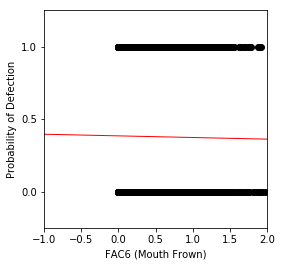

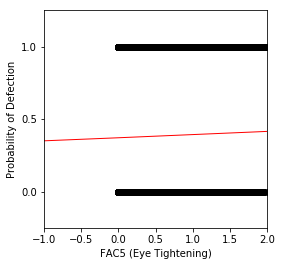

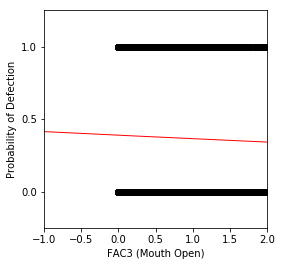

In [101]:
plot_dec_boundary_for_feature("Fac6","FAC6 (Mouth Frown)","Probability of Defection")
plot_dec_boundary_for_feature("Fac5","FAC5 (Eye Tightening)","Probability of Defection")
plot_dec_boundary_for_feature("Fac3","FAC3 (Mouth Open)","Probability of Defection")

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

clf1=LogisticRegression()
clf2=GaussianNB()
# Choose seeds for each 2-fold iterations
seeds = [13, 51, 137, 2465, 347]
# Initialize the score difference for the 1st fold of the 1st iteration 
p_1_1 = 0.0
# Initialize a place holder for the variance estimate
s_sqr = 0.0
# Initialize scores list for both classifiers
scores_1 = []
scores_2 = []
diff_scores = []
# Iterate through 5 2-fold CV
for i_s, seed in enumerate(seeds):
    # Split the dataset in 2 parts with the current seed
    folds = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
    # Initialize score differences
    p_i = np.zeros(2)
    # Go through the current 2 fold
    for i_f, (trn_idx, val_idx) in enumerate(folds.split(df_target, df_target)):
        # Split the data
        trn_x_1, trn_x_2, trn_y = ref_df_features.iloc[trn_idx], novel_df_features.iloc[trn_idx], df_target.iloc[trn_idx]
        val_x_1, val_x_2, val_y = ref_df_features.iloc[val_idx], novel_df_features.iloc[val_idx], df_target.iloc[val_idx]

        # Train classifiers
        clf1.fit(trn_x_1, trn_y)
        clf2.fit(trn_x_2, trn_y)
        # Compute scores
        preds_1 = clf1.predict_proba(val_x_1)[:, 1]
        score_1 = roc_auc_score(val_y, preds_1)
        preds_2 = clf2.predict_proba(val_x_2)[:, 1]
        score_2 = roc_auc_score(val_y, preds_2)
        # keep score history for mean and stdev calculation
        scores_1.append(score_1)
        scores_2.append(score_2)
        diff_scores.append(score_1 - score_2)
        print("Fold %2d score difference = %.6f" % (i_f + 1, score_1 - score_2))
        # Compute score difference for current fold  
        p_i[i_f] = score_1 - score_2
        # Keep the score difference of the 1st iteration and 1st fold
        if (i_s == 0) & (i_f == 0):
            p_1_1 = p_i[i_f]
    # Compute mean of scores difference for the current 2-fold CV
    p_i_bar = (p_i[0] + p_i[1]) / 2
    # Compute the variance estimate for the current 2-fold CV
    s_i_sqr = (p_i[0] - p_i_bar) ** 2 + (p_i[1] - p_i_bar) ** 2 
    # Add up to the overall variance
    s_sqr += s_i_sqr
    
# Compute t value as the first difference divided by the square root of variance estimate
t_bar = p_1_1 / ((s_sqr / 5) ** .5) 

print("Classifier 1 mean score and stdev : %.6f + %.6f" % (np.mean(scores_1), np.std(scores_1)))
print("Classifier 2 mean score and stdev : %.6f + %.6f" % (np.mean(scores_2), np.std(scores_2)))
print("Score difference mean + stdev : %.6f + %.6f" 
      % (np.mean(diff_scores), np.std(diff_scores)))
print("t_value for the current test is %.6f" % t_bar)

Fold  1 score difference = 0.008413
Fold  2 score difference = 0.009868
Fold  1 score difference = 0.009136
Fold  2 score difference = 0.006867
Fold  1 score difference = 0.007513
Fold  2 score difference = 0.008909
Fold  1 score difference = 0.007762
Fold  2 score difference = 0.006488
Fold  1 score difference = 0.007012
Fold  2 score difference = 0.010146
Classifier 1 mean score and stdev : 0.836736 + 0.006257
Classifier 2 mean score and stdev : 0.828525 + 0.006480
Score difference mean + stdev : 0.008211 + 0.001215
t_value for the current test is 5.853051


Performance Expectations